In [45]:
!pip install pandas_gbq
!pip install google-cloud-bigquery

<hr style="border-top: 5px solid orange; margin-top: 1px; margin-bottom: 1px"></hr>

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style="font-size:35px;color:#3665af">Section 1: Data Analysis </span>

This lab will explore the use of Pandas for performing data analysis and MatplotLib for visualizing the results. We will be exploring these tools using a publicly available genome annotation file often used in DNA analysis pipelines. Don't worry if you aren't familiar with genetics, the techniques for managing the data will be the same as any other data set the only difference will be in interpreting the results which is beyond the scope of this assignment.

### Template Data Analysis Pipeline
These are the steps we will be exploring in this lab in relation to a larger data analysis pipeline:
#### 1. Load Data
In this section, we will explore both loading a small file into Pandas directly. In the other section of this assignment we  explore loading data from a remote database using Google BigQuery.

#### 2. Explore the Data
It is very helpful to understand what the data looks like, the types of attributes, number of rows, distribution of values for attributes, etc. Pandas provides functions like ```.head()```, ```.tail()``` and ```.describe()``` to explore the data more analytically. Matplotlib can be used to visualize the data and is very useful for spotting distributions or relations between values. This information can be used to validate our experiment, and inform our predictive model (again, beyond the scope of this assignment).

#### 3. Clean the Data
Data is never perfect, we'll have missing values, extreme outliers, or values that just make no sense. Luckily, Pandas provides functions like ```.isna()``` to identify missing values. Sometimes cleaning the data can be very involved, as in the case of DNA analysis, but this lab focuses on cleaning by removing extraneous data.

***

In [46]:
# import the packages you'll need
import pandas as pd
import matplotlib.pyplot as plt

<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">1. Loading Data </div>

### Gene Annotation
This section of the assignment will begin by loading a tabular file into a Pandas dataframe, exploring that data, then cleaning it and visualizing the results. This file contains gene annotations, which are regions of DNA that are 'read' in a cell and contain all the data that makes up an organism, like a human. 

The first line of code retrieves the data file from an online repository, which is similar in format to a csv file. It can be read using the `read_csv()` method provided by Pandas with tweeked parameters for the specifics of this file type. 

Since this file is not _exactly_ in a supported file format, the process for loading it has been done for you. But some things to note:
1. Pandas has its own command for reading files by type, which loads directly into a dataframe
2. We can define our own column names that will appear as the header of the dataframe when Pandas loads the file 
3. We can specify how Pandas should read the file i.e separator, comment tokens, in chucks, etc.

In [47]:
# grab the file from the internet 
!wget ftp://ftp.ensembl.org/pub/release-85/gff3/homo_sapiens/Homo_sapiens.GRCh38.85.gff3.gz
    
# define the column names, which are not provided in the file
col_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']

# load the file into a Pandas dataframe
# compression = file is compressed using gzip, specify this to read compressed file directly
# sep = separator, how each separate data value is separated
# comment = lines beginning with this symbol are ignored
# low_memory = process whole file at once rather than chunks, prevents mixed types
# header = file has no header, tell method not to look for one
# names = specify custom column names from list above
annotations = pd.read_csv('Homo_sapiens.GRCh38.85.gff3.gz', compression='gzip',
                         sep='\t', comment='#', low_memory=False,
                         header=None, names=col_names)

--2023-03-19 22:33:40--  ftp://ftp.ensembl.org/pub/release-85/gff3/homo_sapiens/Homo_sapiens.GRCh38.85.gff3.gz
           => ‘Homo_sapiens.GRCh38.85.gff3.gz.6’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-85/gff3/homo_sapiens ... done.
==> SIZE Homo_sapiens.GRCh38.85.gff3.gz ... 38469475
==> PASV ... done.    ==> RETR Homo_sapiens.GRCh38.85.gff3.gz ... done.
Length: 38469475 (37M) (unauthoritative)

Homo_sapiens.GRCh38 100%[===================>]  36.69M  3.45MB/s    in 13s     

2023-03-19 22:33:55 (2.79 MB/s) - ‘Homo_sapiens.GRCh38.85.gff3.gz.6’ saved [38469475]



<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">2. Exploring the Data </div>

Start by simply printing out the first 10 rows of the annotations to get a sense for the data and its schema. Pandas has a single method for doing this, which can be found in the [documentation for Pandas Dataframes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). 

### Question 1
Print out the _first 10_ rows of the annotations dataset

In [48]:
# INSERT CODE HERE
print(annotations.head(10))

  seqid  source               type  start        end    score strand phase  \
0     1  GRCh38         chromosome      1  248956422        .      .     .   
1     1       .  biological_region  10469      11240  1.3e+03      .     .   
2     1       .  biological_region  10650      10657    0.999      +     .   
3     1       .  biological_region  10655      10657    0.999      -     .   
4     1       .  biological_region  10678      10687    0.999      +     .   
5     1       .  biological_region  10681      10688    0.999      -     .   
6     1       .  biological_region  10707      10716    0.999      +     .   
7     1       .  biological_region  10708      10718    0.999      -     .   
8     1       .  biological_region  10735      10747    0.999      -     .   
9     1       .  biological_region  10737      10744    0.999      +     .   

                                          attributes  
0  ID=chromosome:1;Alias=CM000663.2,chr1,NC_00000...  
1           external_name=oe %3

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">2.1. Closer Look </div>

There are 25 chromosomes in this human genome (22 numbered + X + Y + MT [MT = mitochondrial, if you're wondering]).
chromosomes are physical divisions of the sequence that can be analysed independently in most cases, making analysis easier by focusing on a smaller portion of the whole sequence. The boundaries of each chromosome in the whole sequence are specified in the annotation file, but first we need to check out how the chromosomes are defined in the annotation file. The chromosome is indicated in the column `seqid`

### Question 2
Print out the _unique_ `seqid` values of the annotations dataset

In [49]:
# INSERT CODE HERE
print(annotations['seqid'].unique())

['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '3' '4' '5' '6' '7' '8' '9' 'GL000008.2' 'GL000009.2' 'GL000194.1'
 'GL000195.1' 'GL000205.2' 'GL000208.1' 'GL000213.1' 'GL000214.1'
 'GL000216.2' 'GL000218.1' 'GL000219.1' 'GL000220.1' 'GL000221.1'
 'GL000224.1' 'GL000225.1' 'GL000226.1' 'KI270302.1' 'KI270303.1'
 'KI270304.1' 'KI270305.1' 'KI270310.1' 'KI270311.1' 'KI270312.1'
 'KI270315.1' 'KI270316.1' 'KI270317.1' 'KI270320.1' 'KI270322.1'
 'KI270329.1' 'KI270330.1' 'KI270333.1' 'KI270334.1' 'KI270335.1'
 'KI270336.1' 'KI270337.1' 'KI270338.1' 'KI270340.1' 'KI270362.1'
 'KI270363.1' 'KI270364.1' 'KI270366.1' 'KI270371.1' 'KI270372.1'
 'KI270373.1' 'KI270374.1' 'KI270375.1' 'KI270376.1' 'KI270378.1'
 'KI270379.1' 'KI270381.1' 'KI270382.1' 'KI270383.1' 'KI270384.1'
 'KI270385.1' 'KI270386.1' 'KI270387.1' 'KI270388.1' 'KI270389.1'
 'KI270390.1' 'KI270391.1' 'KI270392.1' 'KI270393.1' 'KI270394.1'
 'KI270395.1' 'KI270396.1' 'KI270411.1' 'KI270412.1' 'KI270414.1'


### Question 3
Summarize the annotations dataset. Provide the count, mean, std, min, 25%, 50%, 75%, max values 

In [50]:
summary = annotations.describe()
print(summary)

              start           end
count  2.601849e+06  2.601849e+06
mean   7.409822e+07  7.410290e+07
std    5.584042e+07  5.584077e+07
min    1.000000e+00  6.470000e+02
25%    3.159071e+07  3.159528e+07
50%    5.927295e+07  5.928351e+07
75%    1.100164e+08  1.100191e+08
max    2.489450e+08  2.489564e+08


<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">3. Cleaning the Data </div>


You'll notice there are a lot more than 25 values. The extra values come from regions that are annotated but not included in the main genome because it is not clear where they belong. We will ignore these by filtering them out.

We can do this by creating a list of value we want to keep (or reject, but that list would be longer), then query the dataframe for rows with values _isin_ (hint) the list.

### Question 4
Filter and print the number of unique `seqid's`

In [51]:
# list containing seqid values to keep 
chrs = [str(i) for i in range(1,23)] + ['X', 'Y', 'MT']

# query annotations with relevant seqid labels
chrs_only = annotations[annotations['seqid'].isin(chrs)]

# print the number of unique seqid's to make sure you filtered correctly
len(chrs_only['seqid'].unique())

25

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">3.1. Verifying </div>

Now that we have the completed portions (the 25 chromosomes) of the genome separated, lets see how much (percent) of the total genome is unassembled. This will help verify how much of the data we will be missing out on if we only base our analysis on the annotated chromosomes compared to using all annotated data. Luckily, there are rows that sumamrize each region (chromosome and unassembled) and contain information about their entire length.

First, extract only the rows that summarize each `seqid` region (indicated by a `source` equal to GRCh38). Then, find only unassembled regions and create a new Series containing the length of each region. Finally, sum up the lengths of each chromosome we found in the last cell.

### Question 5
Find the length of incomplete regions, find the length of genome sequence, and find the percentage

In [52]:
# A source of GRCh38 is used for rows that provide a summary of each seqid value
GRCh38_only = annotations[annotations.source == 'GRCh38']

# find the length of the incomplete regions
# (length = end - start)
incomplete_regions = GRCh38_only[GRCh38_only.type == 'supercontig']
incomplete_lens = (incomplete_regions.end - incomplete_regions.start)


# then find the total length of the genome sequence (hint: each chromosome's length is given in the end column)
total_len = chrs_only[chrs_only.source == 'GRCh38'].end.sum()

# find the percentage
incomplete_ratio = incomplete_lens.sum() / total_len
'{0:.2f}%'.format(incomplete_ratio * 100)

'0.37%'

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">3.2. Plotting </div>


Now that we have the chromosomes we want to focus on, we can explore the genes within them. Genes can be any length, but it will be helpful to know the range of length values for choosing an appropriate model in the downstream analysis (beyond the scope of this assignment, but think machine learning or statistical model).

The most helpful plot in this situation will likely be a histogram, which will capture the number of genes in a set range of lengths. Which means first, we will find the length of each gene in the annotation file and store as a new column in a dataframe. Then, use Matplotlib to generate a histogram plot with 50 bins for the length and a log-scale y-axis, use the [Matplotlib `hist` documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) to find the parameters needed.

### Question 6
Get the correct genes, compute and store the length of each gene, and create a plot

/tmp/ipykernel_184/2627895410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['length'] = genes['end'] - genes['start'] + 1


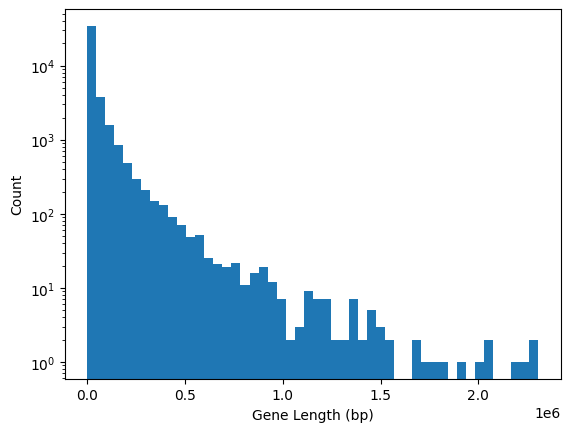

In [53]:
# first, get only genes from annotated regions (type == gene)
genes = chrs_only[chrs_only.type == 'gene']

# then complute the length of each gene and store as a new column
# notice the syntax for adding a new column is fairly simple
genes['length'] = genes['end'] - genes['start'] + 1

# setup the matplotlib hist plot with 50 bins and logarithmic scale on the y-axis
plt.hist(genes['length'], bins=50, log=True)
plt.ylabel('Count')
plt.xlabel('Gene Length (bp)')
plt.show()

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">3.3. More Complex Plot </div>

Now we're going to make a slightly more complex plot to display 3 variables together in a single 2D plot. Specifically we will plot gene count by chromosome and relate it to chromosome length in a scatter plot. 

To do this we will need the lengths of each chromosome, and the number of genes in each chromosome. Finding the lengths will be similar to part 3.1, **but** make sure to keep the `seqid` column to set as the new index to join the two dataframes later.

The genes per chromosome will also require the `seqid` column for joining, and you will need to use the `reset_index()` function before setting `seqid` as the new index.

### Question 7
Get chromosome length, count the genes for each chromosome, join the dataframes, and then plot the count against chromosome length

          length  count
seqid                  
1      248956421   3902
10     133797421   1600
11     135086621   2561
12     133275308   2140
13     114364327    872
14     107043717   1449
15     101991188   1476
16      90338344   1881
17      83257440   2280
18      80373284    766
19      58617615   2412
2      242193528   2806
20      64444166    965
21      46709982    541
22      50818467    996
3      198295558   2204
4      190214554   1751
5      181538258   2002
6      170805978   2154
7      159345972   2106
8      145138635   1628
9      138394716   1659
MT         16568     15
X      156040894   1852
Y       54106422    436


/tmp/ipykernel_184/3900731082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_lens['length'] = chr_lens['end'] - chr_lens['start']


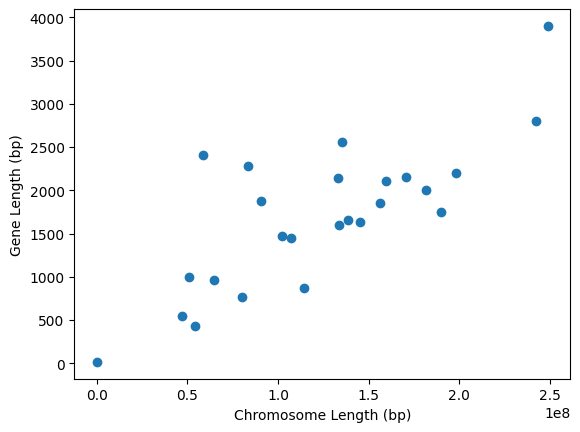

In [54]:
# first, get the chromosome lengths (only need entries with type==chromosome)
chr_lens = chrs_only[chrs_only.type == 'chromosome']
chr_lens['length'] = chr_lens['end'] - chr_lens['start']
chr_lens = chr_lens.reset_index()
chr_lens = chr_lens[['seqid', 'length']].set_index('seqid')
# print(chr_lens)

# next, count genes for each chromosome
genes_per_chr = genes.groupby('seqid').size().reset_index(name='count').set_index('seqid')
# print(genes_per_chr)

# join the dataframes on seqid
plot_frame = pd.merge(chr_lens, genes_per_chr, on='seqid')
print(plot_frame)


# then plot the count against the chromosome length
plt.scatter(plot_frame['length'].values, plot_frame['count'].values )
plt.ylabel('Gene Length (bp)')
plt.xlabel('Chromosome Length (bp)')
# labels for each point
for idx, p in plot_frame.iterrows():
    plt.annotate(idx, xy=(p[1], p[0]))
plt.show()

<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">4. Concluding Remarks </div>


In this part we introduced loading, exploring, and cleaning a small dataset using the Pandas and Matplotlib libraries for Python. This data could be used in later analysis for analyzing genes at the chromosome-level, a process known as Variant Calling in a standard genome analysis pipeline. This data could also be used in a machine learning, statistical, or other predictive model to make data-driven decisions.

Both Pandas and Matplotlib have much more depth than what was presented here, but you can leverage a similar analysis pattern to other datasets using the specific tools to transform and visualize as needed.

<div style="font-size:30px;color:#3665af;background-color:#e1dfb1;padding:10px;">5. Exercise </div>

This exercise will have you load, explore, and clean a dataset. The dataset is called train.csv and can be found in Jupyterhub.

- Load and display the first 10 rows
- Summarize the dataset
- Remove columns with any missing values
- Create a 2D scatter plot with the following 3 variables: LotArea, YearBuilt, and SalePrice

In [55]:
# Load and display the first 10 rows
import pandas as pd
import matplotlib.pyplot as plt

dataframe = pd.read_csv('./train.csv')
print(dataframe.head(10))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl    AllPub  ...       

In [56]:
# Summarize the dataset
summary = dataframe.describe()
print(summary)

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [57]:
# Remove columns with any missing values
dataframe = dataframe.dropna(axis=1, how='any')

print(dataframe)

        Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
0        1          60       RL     8450   Pave      Reg         Lvl   
1        2          20       RL     9600   Pave      Reg         Lvl   
2        3          60       RL    11250   Pave      IR1         Lvl   
3        4          70       RL     9550   Pave      IR1         Lvl   
4        5          60       RL    14260   Pave      IR1         Lvl   
...    ...         ...      ...      ...    ...      ...         ...   
1455  1456          60       RL     7917   Pave      Reg         Lvl   
1456  1457          20       RL    13175   Pave      Reg         Lvl   
1457  1458          70       RL     9042   Pave      Reg         Lvl   
1458  1459          20       RL     9717   Pave      Reg         Lvl   
1459  1460          20       RL     9937   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0       AllPub    Inside       Gtl  ...             0   

      LotArea  YearBuilt  SalePrice
0        8450       2003     208500
1        9600       1976     181500
2       11250       2001     223500
3        9550       1915     140000
4       14260       2000     250000
...       ...        ...        ...
1455     7917       1999     175000
1456    13175       1978     210000
1457     9042       1941     266500
1458     9717       1950     142125
1459     9937       1965     147500

[1460 rows x 3 columns]


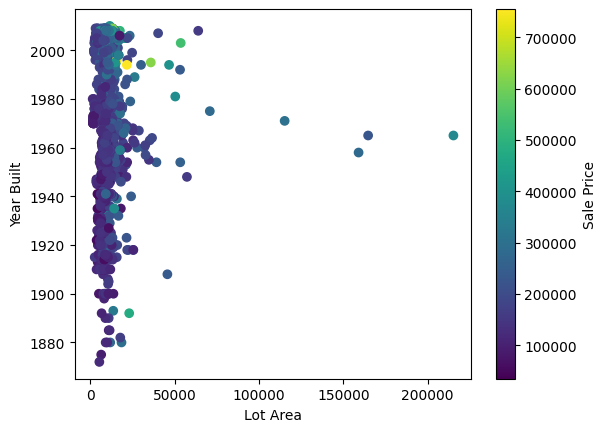

In [67]:
# Create a 2D scatter plot with the following 3 variables: LotArea, YearBuilt, and SalePrice
dataframe = dataframe.reset_index()
dataframe = dataframe[['LotArea', 'YearBuilt', 'SalePrice']]
print(dataframe)

plt.scatter(dataframe['LotArea'], dataframe['YearBuilt'], c=dataframe['SalePrice'])
plt.xlabel('Lot Area')
plt.ylabel('Year Built')
plt.colorbar().set_label('Sale Price')


<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style="font-size:35px;color:#3665af">Section 2: Query Language </span>


In this section of the assignment, we will be using Google BigQuery to query data from the "1000 Genomes Project", a publicly available database that contains information regarding known variants, genetic aberrations that can be the underlying cause of a disease. We will query this information and calculate a single analytical metric, which could normally be used to help verify the results of a DNA analysis pipeline, but in this case the data has been verified already so it can be used to verify your query instead.

Information about the datasets can be found [here](http://googlegenomics.readthedocs.io/en/latest/use_cases/discover_public_data/1000_genomes.html).

In [59]:
# import a library for connecting Pandas to BigQuery
import pandas as pd
import pandas_gbq as pdgbq
from google.oauth2 import service_account
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="bigdatasystems-fall2021-379815-e4d9761d325c.json"

<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">1. Setup Connection </div>

Connect to BigQuery and run a test query, this will require a project with credits, enabling BigQuery API for your project, and authorization for this notebook to use BigQuery.

To enable the BigQuery API for your project go [here](https://console.cloud.google.com/flows/enableapi?apiid=bigquery).

Running the sample query below will provide a prompt to allow access for this notebook.

The pandas BigQuery extension will return the results of each query into a Pandas Dataframe for further analysis.

In [60]:
# here is a template query you can use to test your connection: 
query = 'SELECT * '
query += 'FROM `genomics-public-data.1000_genomes.sample_info` '
query += 'LIMIT 25'

# Insert your BigQuery Project ID Here
# Can be found in the Google web console https://console.cloud.google.com
projectid = "bigdatasystems-fall2021-379815"

# This is your service account key you created in assignment 1.
credentials = service_account.Credentials.from_service_account_file('./bigdatasystems-fall2021-379815-e4d9761d325c.json')

# run a simple query, here we print the results without storing them so you can see it is a dataframe
pdgbq.read_gbq(query, projectid, auth_local_webserver=False, credentials=credentials)

Downloading: 100%|██████████|


,Sample,Family_ID,Population,Population_Description,Gender,Relationship,Unexpected_Parent_Child,Non_Paternity,Siblings,Grandparents,...,In_Final_Phase_Variant_Calling,Has_Omni_Genotypes,Has_Axiom_Genotypes,Has_Affy_6_0_Genotypes,Has_Exome_LOF_Genotypes,EBV_Coverage,DNA_Source_from_Coriell,Has_Sequence_from_Blood_in_Index,Super_Population,Super_Population_Description
0,HG00144,GBR001,GBR,British in England and Scotland,female,mother,HG00155,,,,...,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,,<NA>,EUR,European
1,HG00147,GBR002a,GBR,British in England and Scotland,female,child,,,HG00146,,...,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,,<NA>,EUR,European
2,HG00153,GBR003,GBR,British in England and Scotland,female,child,,,,,...,<NA>,True,<NA>,<NA>,True,NaN,,<NA>,EUR,European
3,HG00248,GBR004,GBR,British in England and Scotland,female,child,HG00247,,,,...,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,,<NA>,EUR,European
4,HG00377,HG00377,FIN,Finnish in Finland,female,,,,,,...,<NA>,True,<NA>,<NA>,True,NaN,,<NA>,EUR,European
5,HG00405,SH001,CHS,"Southern Han Chinese, China",female,child,,,,,...,<NA>,True,<NA>,<NA>,True,NaN,,<NA>,EAS,East Asian
6,HG00408,SH002,CHS,"Southern Han Chinese, China",female,child,,,,,...,<NA>,True,<NA>,<NA>,True,NaN,,<NA>,EAS,East Asian
7,HG00411,SH003,CHS,"Southern Han Chinese, China",male,child,,,,,...,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,,<NA>,EAS,East Asian
8,HG00420,SH006,CHS,"Southern Han Chinese, China",male,child,,,,,...,<NA>,True,<NA>,<NA>,True,NaN,,<NA>,EAS,East Asian
9,HG00423,SH007,CHS,"Southern Han Chinese, China",female,child,,,,,...,<NA>,True,<NA>,<NA>,True,NaN,,<NA>,EAS,East Asian


# <div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">2. Writing a Query </div>


Now we can try a slightly larger query. The 1000 Genomes variant dataset contains over 3TB of genetic variants, which we can run analytical queries on in seconds using BigQuery.

We will begin by querying the dataset to get the reference_name, reference_bases, and alternate_bases that contain only one reference_base *and* one alternate_base. We will test these in the next step.

Query the [genomics-public-data:1000_genomes.variants] table. The results are >40M rows, so you can limit to ~50,000 rows to make the query run in a reasonable amount of time.

BigQuery SQL documentation can be found [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators)

### Question 1
Write a query to get the reference_name, reference_bases, and alternate_bases that contains only <b>one</b> reference_base *and* <b>one</b> alternate_base

In [61]:
query = 'SELECT reference_name, reference_bases, alternate_bases'
query += ' FROM `genomics-public-data.1000_genomes.variants`'
query += ' WHERE LENGTH(reference_bases) = 1'
query += ' AND ARRAY_LENGTH(alternate_bases) = 1'
query += ' LIMIT 50000'

# this query will take some time depending on how many rows you wan
data = pdgbq.read_gbq(query, projectid)
print(data )

Downloading: 100%|██████████|
      reference_name reference_bases alternate_bases
0                 MT               A             [G]
1                 MT               A             [G]
2                  Y               G             [A]
3                  Y               A             [T]
4                  Y               A             [G]
...              ...             ...             ...
49995             22               T             [G]
49996             22               C             [T]
49997             22               T             [C]
49998             22               T             [C]
49999             22               T             [A]

[50000 rows x 3 columns]


<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">3. Interpreting the Results </div>


We have provided two functions that can be applied to the results of the above query. The functions calculate whether a variant was a transition or a transversion. We can compute these, then take the ratio of the sum of each as a metric for verifying our dataset (in this case verifying the query).

Remeber that the query returns a dataframe, so you can use any function from the Pandas library that applies to a dataframe. 

#### Below is an explanation of where this metric comes from for those interested, but reading the below paragraph is not required for this assignment!
Transitions/Transversions are terminology for an interesting effect of the chemistry of DNA, which is made of 4 molecules divided into 2 shapes (pyrimidines and purines). A molecule of one shape is more likely to change to the other of the same shape than it is to one of the opposite shape. We can look at the ratio of these transitions to transversions over our entire dataset or a sampling of it as one of a few metrics to verify if the variants we found are correct. Genomes will have a set range of valid Ti/Tv ratios depending on the organism (humans are ~2.1-2.8). [For more about the molecules and their shapes](https://en.wikipedia.org/wiki/Nucleobase).

### Question 2
Apply the transitions and transversions

In [62]:
pyrimidines = ['A', 'G']
purines = ['T', 'C']

# transitions are a mutation to a base with a similar shape (e.g pyrimidine -> pyrimidine)
def transitions(row):
    if row['reference_bases'] in pyrimidines and row['alternate_bases'] in pyrimidines:
        return 1
    elif row['reference_bases'] in purines and row['alternate_bases'] in purines:
        return 1
    else:
        return 0
    
# transversions are a mutation to a base with a different shape (e.g pyrimidine -> purine)
def transversions(row):
    if row['reference_bases'] in pyrimidines and row['alternate_bases'] in purines:
        return 1
    elif row['reference_bases'] in purines and row['alternate_bases'] in pyrimidines:
        return 1
    else:
        return 0
    
# apply the functions above to the data set 
# queried from the 1000 Genomes database

# ti = apply transitions
data_ti = data.apply(transitions, axis=1)
# tv = apply transversions
data_tv = data.apply(transversions, axis=1)

# the final output should be between 2.1-2.8, which is normal for humans
print(data_ti.sum() / data_tv.sum())

2.159340306744529


<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">4. More Advanced Query </div>


Now we will run a query using a user defined function (UDF) which in this case is small enough to include in the query. We have provided the function (written in Javascript) for you to examine the semantics of if you want to try writing your own in the future. 

This query will require the Google BigQuery client for Python (we are no longer using Pandas) due to the UDF. This will also require a key from your account, instructions for which are provided below.

In [63]:
# Imports the Google Cloud client library
from google.cloud import bigquery
from google.oauth2 import service_account

You will need to add credentials to run BigQuery from this Jupyter notebook
go to [this page](https://console.cloud.google.com/apis/credentials/serviceaccountkey), then
select this notebook for the account, select JSON and generate the key.
the key will download to your device, then either copy it to the directory
where this notebook is located and paste the name of the JSON file below,
or paste the full path to the JSON file

In [64]:
# link credentials file
credentials = service_account.Credentials.from_service_account_file('./bigdatasystems-fall2021-379815-e4d9761d325c.json')

# Instantiates a client
bigquery_client = bigquery.Client(project=projectid, credentials=credentials)

### Question 3
Count the number of transversions that occur in each chromosome using the UDF.

Hint: 
This query will again select the reference_name, and reference_bases and alternate_bases of length one. This time though, we will be counting per reference_name using the UDF provided. The trick here is that alternate_bases are an array of strings in this dataset, so you will need to turn that array into a single string somehow before checking its length. The next cell will print out the results of your query and the query will not actually run until the results are printed (lazily evaluated), so if you want to experiment with different queries, you can use the BigQuery interface [here](https://bigquery.cloud.google.com/table/genomics-public-data:1000_genomes.variants).

In [68]:
# count the number of transversions that occur in each chromosome
# (The  UDF)
query = 'CREATE TEMPORARY FUNCTION tv(ref STRING, alt STRING) '
query += 'RETURNS INT64 '
query += r'''LANGUAGE js AS """ '''
query += 'var pyr = ["A", "G"]; '
query += 'var pur = ["T", "C"]; '
query += 'if ((pyr.includes(ref) && pur.includes(alt)) || (pur.includes(ref) && pyr.includes(alt))) {return 1;} '
query += 'else {return 0;}'
query += r''' """; '''

# select the reference_name and the count of tv's using the above function, note function name and parameters above
query += 'SELECT reference_name, COUNTIF(tv(reference_bases, ARRAY_TO_STRING(alternate_bases, "")) = 1) AS num_transversions '
query += 'FROM `genomics-public-data.1000_genomes.variants` '
query += 'WHERE LENGTH(reference_bases) = 1 AND ARRAY_LENGTH(alternate_bases) = 1 GROUP BY reference_name'

data = bigquery_client.query(query)

In [69]:
# run this to print the results of your query
# notice how this method differs from the Pandas extension that stores the query results in a dataframe
print("Chromosome, Count")
for row in data:
    print(str(row[0]) + ', ' + str(row[1]))

Chromosome, Count
17, 291556
X, 467942
20, 245130
2, 1018156
22, 135552
10, 562460
1, 889580
9, 522930
3, 857028
Y, 7055
21, 154048
18, 327480
16, 392356
19, 227907
11, 579209
4, 857935
8, 705030
13, 418380
MT, 96
6, 733725
15, 343954
7, 677923
5, 784690
12, 546758
14, 379033


<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">5. Concluding Remarks </div>


This was a quick look at BigQuery for running analytical queries on a publically available genomics dataset to explore the Ti/Tv ratio. This technique can be applied to DNA sequencing experiments to verify the results of the data cleaning and analysis. If you are interested in the DNA analysis pipeline and BigQuery, an even more advanced version of this query with UDF's can be found [here](https://cloud.google.com/life-sciences/docs/how-tos/analyze-variants).

BigQuery is similar to other big data query languages such as Apache Hive or Impala, so you can apply the information here to the other languages. 

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>